# Semantic mapping and Kriging

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.stats import norm
from sklearn.preprocessing import LabelEncoder
import skbio
from pykrige import OrdinaryKriging

In [2]:
# Define variables
mapsoutputdir = '../outputs/maps/' # directory where you want the semantic maps to be saved
krigingstatsdir = '../outputs/krigingstats/' # directory where you want the kriging stats to be saved
paralleldatapath = '../outputs/when-latamecarr-withgrams.csv' # parallel dataset, containing one col per language, one context per row. Each cell is the word used by the language in col for the context in row
glottologmappingpath = '../datasets/glottolog_withfams.csv'
# iso code of languages you want to plot from the paralleldata:
languages = ["aca","acf","acr","acu","agr","agu","ake","ame","amr","amu","apn","apu","apy","arl","arn","auc","ayo","ayr","azg","azz","bao","bkq","bmr","boa","bsn","bzd","bzj","caa","cab","cac","cag","cak","cao","cap","car","cas","cav","cax","cbc","cbi","cbr","cbs","cbt","cbu","cbv","cco","ceg","chd","chf","chq","chz","cjo","cjp","cle","cly","cni","cnl","cnt","coe","cof","cok","con","cot","cpa","cpb","cpc","cpu","cpy","crn","crq","crt","cso","cta","ctp","ctu","cub","cuc","cui","cuk","cul","cut","cux","cya","des","djk","emp","enx","ese","gnw","gub","guc","gug","guh","gui","gum","gun","guo","guq","gvc","gym","gyr","hat","hch","hix","hns","hto","hub","hus","huu","huv","icr","ign","inb","ixl","jac","jam","jic","jiv","jvn","kaq","kbc","kbh","kek","kgk","kgp","kjb","knj","kog","kpj","kvn","kwi","kyz","lac","leg","maa","maj","mam","maq","mau","mav","maz","mbc","mbj","mbl","mca","mcb","mcd","mcf","mco","mfy","mib","mie","mig","mih","mil","mio","miq","mir","mit","miy","miz","mjc","mks","moc","mop","mpm","mto","mtp","mxb","mxp","mxq","mxt","mxv","myu","myy","mza","mzh","mzl","nab","nch","ncj","ncl","ngu","nhd","nhe","nhg","nhi","nhw","nhx","nhy","noa","not","npl","nsu","ntp","ote","otm","otn","otq","ots","oym","pab","pad","pah","pap","pbb","pbc","pib","pio","pir","plg","pls","plu","poe","poh","poi","pps","pua","qub","quc","quf","qug","quh","qul","qup","quw","quy","quz","qva","qvc","qve","qvh","qvi","qvm","qvn","qvo","qvs","qvw","qvz","qwh","qxh","qxl","qxn","qxo","qxr","rkb","sab","sey","shp","sja","snn","sri","srm","srn","srq","stp","tac","tar","tav","tca","tee","ter","tfr","tku","tna","tnc","tob","toc","toj","too","top","tos","tpp","tpt","tqb","trc","trn","trq","tsz","ttc","tue","tuf","tuo","txu","tzh","tzj","tzo","ura","urb","usp","var","vmy","wap","way","wca","xav","xsu","xtd","xtm","xtn","yaa","yad","yan","yaq","ycn","yua","yuz","zaa","zab","zac","zad","zae","zai","zam","zao","zar","zas","zat","zav","zaw","zca","zos","zpc","zpi","zpl","zpm","zpo","zpq","zpt","zpu","zpv","zpz","zsr","ztq","zty"]

In [ ]:
# Import Glottolog mapping from iso codes to language names and families for mapping
lang_names_fams_df = pd.read_csv(glottologmappingpath)

# This assumes the first two columns are the sentence and the sentence_id, hence why they are removed
# Change or remove df = df.iloc[:, 2:] accordingly
parallel_df = pd.read_csv(paralleldatapath, low_memory=False)
# parallel_df = parallel_df.iloc[:, 2:]
parallel_df

In [4]:
# Convert strings to numeric using LabelEncoder
label_encoder = LabelEncoder()
df_encoded = parallel_df.apply(label_encoder.fit_transform)

# Compute pairwise Hamming distances
distances = pdist(df_encoded.values, metric='hamming')

# Convert to square matrix
dist_matrix = squareform(distances)

# Save the matrix to a CSV file without header if needed, else comment out
# pd.DataFrame(dist_matrix).to_csv('matrix.csv', index=False, header=False)

# Sanity check
print(dist_matrix.shape)

(876, 876)


/Users/npedrazzini/Library/Caches/pypoetry/virtualenvs/ngram-typology-L59eT3NA-py3.10/lib/python3.10/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.17301541484753172 and the largest is 15.762004682738677.
  warn(


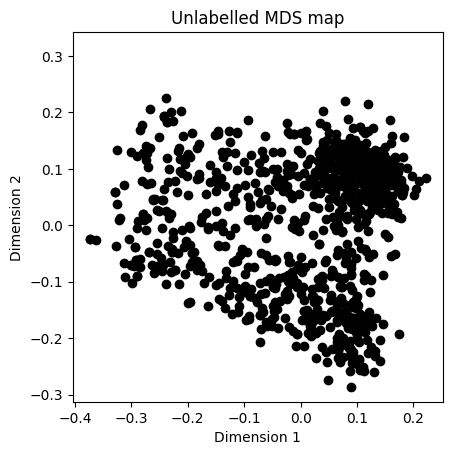

In [5]:
## Metric Multi Dimensional Scaling (or 'Principal Coordinate Analysis')
PCoA = skbio.stats.ordination.pcoa(dist_matrix)
dims1_2df = PCoA.samples[['PC1', 'PC2']]
plt.scatter(dims1_2df['PC1'],dims1_2df['PC2'],c='black')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Unlabelled MDS map')
plt.axis('square')
plt.savefig(f'{mapsoutputdir}plainmds.png')
plt.show()

In [6]:
## Calculate boundaries for better areas (similarly to `boundary' in qlcVisualize in R)
testdf = dims1_2df[['PC1', 'PC2']]

grid=50
tightness="auto"

p = np.array(testdf)
if tightness == "auto":
    # This is the Python translation of the R function MASS::bandwidth.nrd, works exactly
    r = np.percentile(p[:,0], [25, 75])
    h = (r[1] - r[0]) / 1.34
    tightness = 4 * 1.06 * min(np.sqrt(np.var(p[:,0])), h) * len(p[:,0])**(-1/5)

x = p[:,0]
y = p[:,1]
lims = [np.min(x), np.max(x), np.min(y), np.max(y)]
h = tightness
n = grid
nx = len(x)
print('nx',nx)
n = np.repeat(n, 2)
print('n',n)
gx = np.linspace(lims[0], lims[1], n[0])
print('gx',gx)
gy = np.linspace(lims[2], lims[3], n[1])
print('gy',gy)
h = np.repeat(h, 2)
print('h',h)
h = h / 4
print('h',h)
ax = np.subtract.outer(gx, x) / h[0]
print('ax',ax)
ay = np.subtract.outer(gy, y) / h[1]
print('ay',ay)
matrax = np.reshape(norm.pdf(ax), (-1, nx), order='F')
matray = np.reshape(norm.pdf(ay), (-1, nx), order='F')
z = np.dot(matrax, matray.T) / (nx * h[0] * h[1])
k = {'x': gx, 'y': gy, 'z': z}

density=0.40
box_offset=0.1
tightness=tightness
manual=None
plot=True
zeros = np.where(k['z'] < density)
print('zeros',zeros)
zeroX = k['x'][zeros[1]]
zeroY = k['y'][zeros[0]]
rX = np.ptp(x) * box_offset
rY = np.ptp(y) * box_offset

def bandwidth_nrd(x):
    r = np.percentile(x, [25, 75])
    h = (r[1] - r[0]) / 1.34
    return 4 * 1.06 * min(np.sqrt(np.var(x)), h) * len(x) ** (-1/5)

pXmin = np.min(k['x']) - rX
pXmax = np.max(k['x']) + rX
pYmin = np.min(k['y']) - rY
pYmax = np.max(k['y']) + rY

borderX = np.concatenate([
    k['x'],                  # k$x
    k['x'],                  # k$x
    np.tile(pXmin, len(k['y'])),  # rep(pXmin, times = length(k$y))
    np.tile(pXmax, len(k['y'])),  # rep(pXmax, times = length(k$y))
    np.array([pXmin]), np.array([pXmin]), np.array([pXmax]), np.array([pXmax])   # pXmin, pXmin, pXmax, pXmax
])

borderY = np.concatenate([
    np.tile(pYmin, len(k['x'])),  # rep(pYmin, length(k$x))
    np.tile(pYmax, len(k['x'])),  # rep(pYmax, length(k$x))
    k['y'],                       # k$y
    k['y'],                       # k$y
    np.array([pYmin]), np.array([pYmax]), np.array([pYmin]), np.array([pYmax])
])

zeros = np.column_stack((np.concatenate([zeroX, borderX, [None]]), np.concatenate([zeroY, borderY, [None]])))
mask = np.all(zeros != None, axis=1)

# Apply the mask to filter out rows with None values
arr_filtered = zeros[mask]
h0 = np.zeros(arr_filtered.shape[0], dtype=int)
x = np.vstack([np.array(dims1_2df[['PC1', 'PC2']]), arr_filtered])

x1 = np.linspace(min(x[:,0])-0.07,max(x[:,0])+0.07,100)
y1 = np.linspace(min(x[:,1])-0.07,max(x[:,1])+0.07,100)
xgrid,ygrid = np.meshgrid(x1,y1)

nx 876
n [50 50]
gx [-0.37375026 -0.36159923 -0.3494482  -0.33729717 -0.32514614 -0.31299511
 -0.30084408 -0.28869305 -0.27654202 -0.26439099 -0.25223996 -0.24008894
 -0.22793791 -0.21578688 -0.20363585 -0.19148482 -0.17933379 -0.16718276
 -0.15503173 -0.1428807  -0.13072967 -0.11857864 -0.10642761 -0.09427658
 -0.08212555 -0.06997452 -0.05782349 -0.04567246 -0.03352143 -0.0213704
 -0.00921938  0.00293165  0.01508268  0.02723371  0.03938474  0.05153577
  0.0636868   0.07583783  0.08798886  0.10013989  0.11229092  0.12444195
  0.13659298  0.14874401  0.16089504  0.17304607  0.1851971   0.19734813
  0.20949916  0.22165018]
gy [-0.28692816 -0.27647019 -0.26601222 -0.25555425 -0.24509628 -0.23463831
 -0.22418034 -0.21372238 -0.20326441 -0.19280644 -0.18234847 -0.1718905
 -0.16143253 -0.15097456 -0.14051659 -0.13005862 -0.11960065 -0.10914268
 -0.09868471 -0.08822674 -0.07776877 -0.0673108  -0.05685283 -0.04639486
 -0.03593689 -0.02547893 -0.01502096 -0.00456299  0.00589498  0.01635295
  0.

In [7]:
tightness

0.14669614740528558

In [12]:
# Assuming you want to process the top N items
num_top_items = 5  # Adjust this as needed

# Other variables and configurations
# levels = [0.85, 0.90, 0.95]
levels = [0.85, 0.90, 0.95]
freq_threshold = round(len(parallel_df) / 100 * 3)
# freq_threshold = 5

markers = ["o", ",", "o", "v", "^", "s","*",">", "<", "p"]
colors = ['r', 'b', 'g', 'y', 'c', 'm', 'orange', 'brown', 'pink', 'k']

levels_thickness = {
    levels[0]: 0.5,  # Level 0.2 with line thickness 0.5
    levels[1]: 1.0,  # Level 0.4 with line thickness 1.0
    levels[2]: 1.5,  # Level 0.6 with line thickness 1.5
    # Add more levels and thicknesses as needed
}


In [ ]:
lang_names_fams_df['iso'] = lang_names_fams_df['iso'].astype(str)

for language in languages:

    print(f'Now processing {language}')

    langname = list(lang_names_fams_df[lang_names_fams_df['iso']==language]['name'])[0]
    nameoffam = list(lang_names_fams_df[lang_names_fams_df['iso']==language]['nameoffam'])[0]

    occurrences = parallel_df.filter(like=language).copy()
    language_codes = occurrences.columns
    for language_code in language_codes:

        top_items = list(occurrences[language_code].value_counts().head(num_top_items).index)

        other_label_added = False

        plt.scatter(dims1_2df['PC1'], dims1_2df['PC2'], c='grey', s=2, marker='.', alpha=0.3)

        for item_index, top_item in enumerate(top_items):
            if top_item != 'NOMATCH':
                occurrences[top_item] = occurrences[language_code] == top_item

                occurrences['x'] = dims1_2df['PC1'].values
                occurrences['y'] = dims1_2df['PC2'].values

                Y = np.concatenate((occurrences[top_item], h0))
                
                # Perform Ordinary Kriging
                OK = OrdinaryKriging(x[:, 0], x[:, 1], Y,
                                    variogram_model='gaussian',
                                    nlags=4,
                                    coordinates_type='geographic',
                                    variogram_parameters={'sill': 0.3, 'range': 0.5, 'nugget': 0.2})

                zgrid, _ = OK.execute('grid', x1, y1, mask=False)
                zgrid_normalized = (zgrid - zgrid.min()) / (zgrid.max() - zgrid.min())

                # Plotting
                means = occurrences[occurrences[top_item] == 1]
                color = colors[item_index % len(colors)] if top_item != 'NOMATCH' else 'black'
                marker = markers[item_index % len(markers)] if top_item != 'NOMATCH' else '<'

                plt.scatter(means['x'], means['y'], c=color, s=7, marker=marker, label=f'{top_item}', alpha=0.5)

                if len(means) >= freq_threshold:
                    # Example levels and their corresponding line thicknesses

                    for level, thickness in levels_thickness.items():
                        plot = plt.contour(xgrid, ygrid, zgrid_normalized, levels=[level], colors=color, linewidths=thickness)
                        plt.clabel(plot, inline=True, fontsize=7)

                # if occurrences[top_item].sum() >= freq_threshold:
                #     plot = plt.contour(xgrid, ygrid, zgrid_normalized, levels=levels, colors=color,linewidths=0.1)
                #     plt.clabel(plot, inline=True, fontsize=7)

                    # Check if test points are inside any of the contour paths
                    isitinarea = []
                    for (point1, point2) in np.array(testdf[['PC1', 'PC2']]):
                        test_point = (point1, point2)
                        result = any(path.contains_point(test_point) for path in plot.collections[0].get_paths() if plot.levels[0] == 0.85)
                        isitinarea.append(1 if result else 0)

                    isitinarea = np.array(isitinarea)
                    np.save(f'{krigingstatsdir}{language_code}_{top_item}.npy', isitinarea)

        # Rest of the code remains unchanged
        plt.scatter([], [], c='grey', s=2, marker='.', alpha=0.3, label='other')

        plt.axis('square')
        plt.xlabel('Dimension 1')
        plt.ylabel('Dimension 2')
        plt.title(f'{langname} [{language}] ({nameoffam})')
        # plt.title('Ancient Greek')

        plt.legend(fontsize="7")
        plt.savefig(f'{mapsoutputdir}{language_code}-kriging.png', dpi=300)
        plt.show()